In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn import metrics 
from scipy import stats

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [2]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [3]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v3_annot.h5ad')
adata

CPU times: user 189 ms, sys: 72 ms, total: 261 ms
Wall time: 263 ms


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

In [4]:
# %%time
# # UMAP
# embed = umap.UMAP(n_components=2, random_state=0).fit_transform(adata.X)
# adata.obs['embed_1'] = embed[:,0]
# adata.obs['embed_2'] = embed[:,1]

# adata.write('../data_dump/P38_glut_genes_v3_annot.h5ad')

#  Utilities

In [5]:
def get_r2(y, yhat):
    """
    """
    r2 = 1-np.power(y-yhat, 2).sum()/np.power(y-np.mean(y), 2).sum()
    return r2

def get_mse(y, yhat):
    """
    """
    mse = np.power(y-yhat, 2).mean()
    return mse
    
def get_pearsonr(y, yhat):
    """
    """
    r, p = stats.pearsonr(y, yhat)
    return r

In [6]:
def regression_pipe(X, y, alpha):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    ygs = np.empty(len(y))
    yps = np.empty(len(y))
    
    mse_s = []
    l0s = []
    l1s = []
    
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # build model
        model = Lasso(alpha=alpha, random_state=0)
        # train
        model.fit(X_train, y_train)
        # test
        yp = model.predict(X_test)
        # evaluation
        mse = np.power(yp-y_test, 2).mean()
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()

        # add
        l0s.append(l0)
        l1s.append(l1)
        mse_s.append(mse)
        
        ygs[test_idx] = y_test
        yps[test_idx] = yp
    
    return ygs, yps, mse_s, l0s, l1s

def tuning_regression(X, y, alphas):
    """
    """
    res = []
    ressum = []
    for alpha in alphas:
        print(alpha)
        # run
        ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
        res.append((ygs, yps, mse_s, l0s, l1s))
        ressum.append({
           'Reg Strength': alpha,
           'MSE': np.mean(mse_s),
           'r2': get_r2(ygs, yps),
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })
    
    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_regression_pipe(ax, ygs, ypgs, clusters, title="", legend=True):
    """
    """
    r2 = get_r2(ygs, yps)
    dfplot = pd.DataFrame()
    dfplot['Ground truth'] = ygs
    dfplot['Prediction'] = yps
    dfplot['Cluster'] = clusters 
    sns.scatterplot(data=dfplot, 
                    x='Ground truth',
                    y='Prediction',
                    hue='Cluster',
                    hue_order=np.sort(dfplot['Cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                   )

    scale = min(max(ygs), max(yps))
    ax.plot([0, scale], [0, scale], color='k', linestyle='--')
    ax.set_title(f"{title}")
    ax.text(1, 0.1, f'r2={r2:.2f}', ha='right', transform=ax.transAxes)
    sns.despine(ax=ax)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.get_legend().remove()
    
def plot_ressum_reg(ressum, evalcol='AUPR', scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['Reg Strength'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['Reg Strength'], ressum[evalcol], '-o')
    ax.set_ylabel(evalcol)
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()

# Regression example

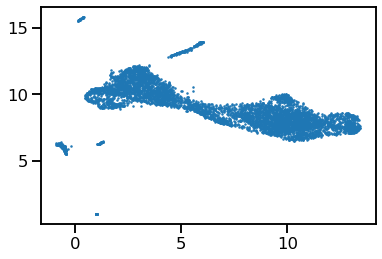

In [7]:
plt.scatter(adata.obs['embed_1'], 
            adata.obs['embed_2'],
            s=1,
           )

(5837, 86) (5837,)


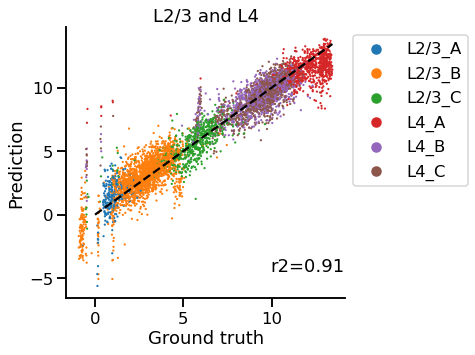

In [8]:
# data
X = adata.X
y = adata.obs['embed_1'].values 
clusters = adata.obs['cluster'].values
print(X.shape, y.shape)

# run
alpha = 1e-3 
ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
                                   
# vis
fig, ax = plt.subplots(1,1,figsize=(5*1,5))
plot_regression_pipe(ax, ygs, yps, clusters, title='L2/3 and L4')
plt.show()

# L2/3 and L4 Tuning

In [9]:
# data
X = adata.X
y = adata.obs['embed_1'].values 
clusters = adata.obs['cluster'].values
print(X.shape, y.shape)

(5837, 86) (5837,)


In [10]:
# run
# alphas = np.linspace(4e-4, 5e-4, 11) # micro
alphas = np.logspace(-4, 4, 9) # macro
# alphas = np.linspace(1e-4, 1e-3, 10) # macro
# alphas = [1, 10]

res, ressum = tuning_regression(X, y, alphas)

0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0


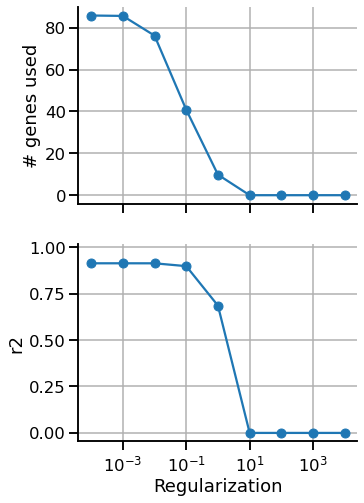

In [11]:
plot_ressum_reg(ressum, evalcol='r2', scale='log')

In [25]:
# c = 5e-4
for alpha in alphas:
    # which gene?
    model = Lasso(alpha=alpha, random_state=0)
    model.fit(X, y)
    cond = np.abs(model.coef_.reshape(-1,)) > 1e-6
    used_genes = adata.var[cond].index.values
    print(f'alpha={alpha:.2g}, {len(used_genes)} genes used: ', used_genes)

alpha=0.0001, 86 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntn6'
 'Cntnap1' 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10'
 'Epha3' 'Epha6' 'Foxp1' 'Fst' 'Gabrg3' 'Gpc5' 'Gpc6' 'Gria3' 'Grik3'
 'Grm1' 'Grm8' 'Igfbp7' 'Igfn1' 'Igsf11' 'Igsf9b' 'Kcna1' 'Kcnh5' 'Kcnip3'
 'Kcnn3' 'Kcnq5' 'Kirrel3' 'Lgi2' 'Lynx1' 'Mdga1' 'Meis2' 'Met' 'Mkx'
 'Ncam2' 'Ngb' 'Nptx2' 'Nr4a3' 'Nrp1' 'Ntng1' 'Otof' 'Pcdh15' 'Pcdh19'
 'Penk' 'Pld5' 'Plxnd1' 'Pou3f2' 'Ptpru' 'Rfx3' 'Robo1' 'Robo3' 'Rorb'
 'Rrad' 'S100a6' 'Scn1a' 'Sdk2' 'Sema4a' 'Sema6a' 'Sema6d' 'Sorcs3' 'Sox5'
 'Stard8' 'Tbr1' 'Tenm1' 'Trpc6' 'Whrn' 'Wnt4']
alpha=0.001, 85 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntnap1'
 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10' 'Epha3'
 'Epha6' 'Foxp1' 'Fst' 'Gab

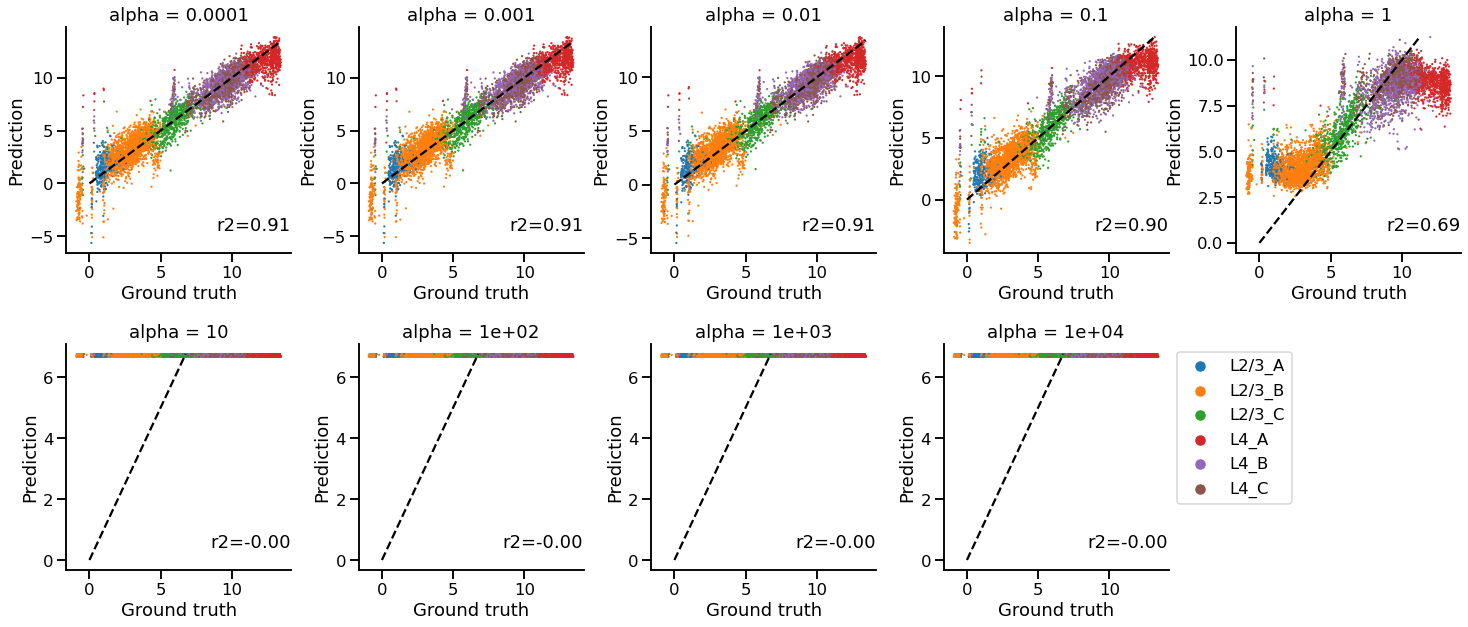

In [13]:
n = len(alphas)
nx = 5
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
for i, (oneres, alpha, ax) in enumerate(zip(res, alphas, axs.flat)):
    if i < n-1:
        legend = False
    else:
        legend = True
        
    ygs, yps, _, _, _ = oneres
    plot_regression_pipe(ax, ygs, yps, clusters, title='', legend=legend)
    ax.set_title(f'alpha = {alpha:.2g}')
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
    
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

# L2/3 only tuning

In [14]:
# data
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()
X = adatasub.X
y = adatasub.obs['embed_1'].values 
clusters = adatasub.obs['cluster'].values
print(X.shape, y.shape)

(2818, 86) (2818,)


In [15]:
# run
# alphas = np.linspace(4e-4, 5e-4, 11) # micro
alphas = np.logspace(-4, 4, 9) # macro
# alphas = np.linspace(1e-4, 1e-3, 10) # macro
# alphas = [1, 10]

res, ressum = tuning_regression(X, y, alphas)

0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0


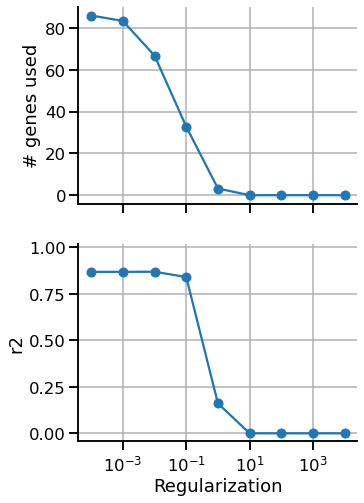

In [16]:
plot_ressum_reg(ressum, evalcol='r2', scale='log')

In [24]:
# c = 5e-4
for alpha in alphas:
    # which gene?
    model = Lasso(alpha=alpha, random_state=0)
    # model.fit(X[:int(0.8*len(y))], y[:int(0.8*len(y))])
    model.fit(X, y)
    cond = np.abs(model.coef_.reshape(-1,)) > 1e-6
    used_genes = adata.var[cond].index.values
    print(f'alpha={alpha:.2g}, {len(used_genes)} genes used: ', used_genes)

alpha=0.0001, 86 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntn6'
 'Cntnap1' 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10'
 'Epha3' 'Epha6' 'Foxp1' 'Fst' 'Gabrg3' 'Gpc5' 'Gpc6' 'Gria3' 'Grik3'
 'Grm1' 'Grm8' 'Igfbp7' 'Igfn1' 'Igsf11' 'Igsf9b' 'Kcna1' 'Kcnh5' 'Kcnip3'
 'Kcnn3' 'Kcnq5' 'Kirrel3' 'Lgi2' 'Lynx1' 'Mdga1' 'Meis2' 'Met' 'Mkx'
 'Ncam2' 'Ngb' 'Nptx2' 'Nr4a3' 'Nrp1' 'Ntng1' 'Otof' 'Pcdh15' 'Pcdh19'
 'Penk' 'Pld5' 'Plxnd1' 'Pou3f2' 'Ptpru' 'Rfx3' 'Robo1' 'Robo3' 'Rorb'
 'Rrad' 'S100a6' 'Scn1a' 'Sdk2' 'Sema4a' 'Sema6a' 'Sema6d' 'Sorcs3' 'Sox5'
 'Stard8' 'Tbr1' 'Tenm1' 'Trpc6' 'Whrn' 'Wnt4']
alpha=0.001, 85 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntnap1'
 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10' 'Epha3'
 'Epha6' 'Foxp1' 'Fst' 'Gab

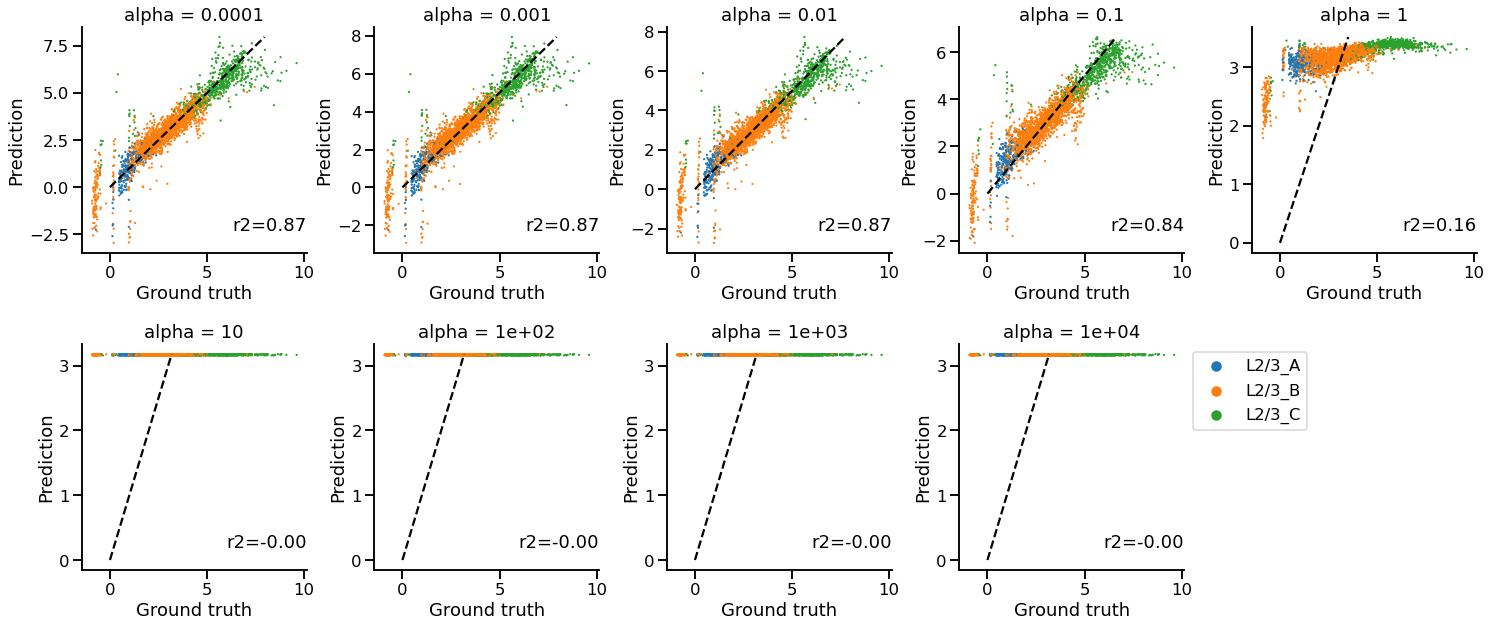

In [18]:
n = len(alphas)
nx = 5
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
for i, (oneres, alpha, ax) in enumerate(zip(res, alphas, axs.flat)):
    if i < n-1:
        legend = False
    else:
        legend = True
        
    ygs, yps, _, _, _ = oneres
    plot_regression_pipe(ax, ygs, yps, clusters, title='', legend=legend)
    ax.set_title(f'alpha = {alpha:.2g}')
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
    
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()